<div style="border: 8px solid #004080; padding: 30px; font-family: Arial, sans-serif; text-align: center;">

<h2 style="margin: 0; font-style: italic;">RÉPUBLIQUE DU SÉNÉGAL</h2>
<h4 style="margin-top: 5px;">Un Peuple – Un But – Une Foi</h4>

<img src="..\docs\img\Republique_du_Senegal.jpg" alt="Logo République du Sénégal" style="width: 90px; margin-top: 10px;">

<hr style="border: 1px solid #004080; margin: 20px 0;">

<h3 style="font-style: italic;">Agence Nationale de la Statistique et de la Démographie (ANSD)</h3>
<img src="..\docs\img\ANSD.jpg" alt="Logo ANSD" style="width: 110px; margin-top: 10px;">

<h3 style="font-style: italic;">École Nationale de la Statistique et de l'Analyse Économique Pierre Ndiaye</h3>
<img src="..\docs\img\ENSAE-Dakar-logo.jpg" alt="Logo ENSAE" style="width: 110px; margin-top: 10px;">

<hr style="border: 1px solid #004080; margin: 30px 0;">

<div style="background-color: #004080; color: white; font-weight: bold; padding: 12px; display: inline-block; border-radius: 5px;">
    Projet de Machine Learning 2
</div>

<h3 style="margin-top: 30px;">Sujet :</h3>
<h2 style="font-style: italic; color: #004080;">Churn Score</h2>

<hr style="border: 1px dashed #004080; margin: 30px 0;">

<h3>Rédigé par :</h3>
<p style="font-size: 18px; line-height: 1.8;">
    Famara Sadio<br>
    Saran Ndiaye<br>
    Amadou Youm<br>
    Sié Rachid Traoré<br>
    <span style="font-size: 16px; font-style: italic;">Elèves ingénieurs statisticiens économistes</span>
</p>

<h3>Sous la supervision de :</h3>
<p style="font-size: 18px;">
    Mously Diaw<br>
    <span style="font-size: 16px; font-style: italic;">Data Scientist / ML Engineer / Auto-Entrepreneur</span>
</p>

<hr style="border: 0.5px solid #004080; margin: 30px 0;">

<p style="font-weight: bold; font-size: 16px;">© ISE2 – Juin 2025</p>
</div>


<div style="background-color: RGB(80,115,152); text-align: center;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"> Churn score </h1>
</div>

> ## **Paramétrage**

In [37]:
%pip install dill imblearn pendulum ucimlrepo yellowbrick loguru

In [38]:
%pip install--upgrade kagglehub

Note: you may need to restart the kernel to use updated packages.


ERROR: unknown command "install--upgrade" - maybe you meant "install"



In [39]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
from imblearn.pipeline import Pipeline as imb_Pipeline
from loguru import logger
from sklearn import set_config

import warnings
warnings.filterwarnings(action='ignore')

set_config(display='diagram')
pd.set_option("display.max_columns", None)


In [40]:
plt.style.use('seaborn-v0_8-whitegrid')

In [41]:
def afficher_dataframes(dfs, head_n=5):
    """
    Affiche les informations d'un DataFrame ou d'un dictionnaire de DataFrames.

    Paramètres :
    - dfs : un DataFrame ou un dictionnaire {nom: DataFrame}
    - head_n : nombre de lignes à afficher avec head()
    """

    if isinstance(dfs, pd.DataFrame):
        # Cas d’un seul DataFrame
        print(f"\n📄 DESCRIPTION")
        print(f"📐 Taille : {dfs.shape[0]} lignes × {dfs.shape[1]} colonnes")
        print(f"🧠 Colonnes : {dfs.columns.tolist()}")
        display(dfs.head(head_n))

    elif isinstance(dfs, dict):
        if not dfs:
            print("⚠️ Dictionnaire vide.")
            return

        for name, df in dfs.items():
            if isinstance(df, pd.DataFrame):
                print(f"\n📄 Nom : {name}")
                print(f"📐 Taille : {df.shape[0]} lignes × {df.shape[1]} colonnes")
                print(f"🧠 Colonnes : {df.columns.tolist()}")
                display(df.head(head_n))
            else:
                print(f"⚠️ L’objet '{name}' n’est pas un DataFrame.")

    else:
        print("❌ Entrée non valide : fournir un DataFrame ou un dictionnaire de DataFrames.")


> ## **Collecte des données**

**About Dataset**

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry.


It contains information on bank customers who either left the bank or continue to be a customer. 

The dataset includes the following attributes:

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides (France, Spain or Germany)

Gender: The customer's gender (Male or Female)

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (1 = yes, 0 = no)

In [42]:
train_df = pd.read_csv("../data/playground-series-s4e1/train.csv")
test_df = pd.read_csv("../data/playground-series-s4e1/test.csv")
sample_df = pd.read_csv("../data/playground-series-s4e1/sample_submission.csv")

In [43]:
afficher_dataframes(train_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [44]:
afficher_dataframes(test_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 13 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


In [45]:
afficher_dataframes(sample_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 2 colonnes
🧠 Colonnes : ['id', 'Exited']


,id,Exited
0,165034,0.5
1,165035,0.5
2,165036,0.5
3,165037,0.5
4,165038,0.5


> ## ***Vue d'ensemble des données***

In [46]:
train_df.shape,test_df.shape,sample_df.shape

((165034, 14), (110023, 13), (110023, 2))

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110023 entries, 0 to 110022
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               110023 non-null  int64  
 1   CustomerId       110023 non-null  int64  
 2   Surname          110023 non-null  object 
 3   CreditScore      110023 non-null  int64  
 4   Geography        110023 non-null  object 
 5   Gender           110023 non-null  object 
 6   Age              110023 non-null  float64
 7   Tenure           110023 non-null  int64  
 8   Balance          110023 non-null  float64
 9   NumOfProducts    110023 non-null  int64  
 10  HasCrCard        110023 non-null  float64
 11  IsActiveMember   110023 non-null  float64
 12  EstimatedSalary  110023 non-null  float64
dtypes: float64(5), int64(5), object(3)
memory usage: 10.9+ MB


> ## **Nettoyage des données**

In [49]:
afficher_dataframes(train_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [50]:
afficher_dataframes(test_df,head_n=5)


📄 DESCRIPTION
📐 Taille : 110023 lignes × 13 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,165034,15773898,Lucchese,586,France,Female,23.0,2,0.00,2,0.0,1.0,160976.75
1,165035,15782418,Nott,683,France,Female,46.0,2,0.00,1,1.0,0.0,72549.27
2,165036,15807120,K?,656,France,Female,34.0,7,0.00,2,1.0,0.0,138882.09
3,165037,15808905,O'Donnell,681,France,Male,36.0,8,0.00,1,1.0,0.0,113931.57
4,165038,15607314,Higgins,752,Germany,Male,38.0,10,121263.62,1,1.0,0.0,139431.00


> ## **Y'a t-il des valeurs manquantes**

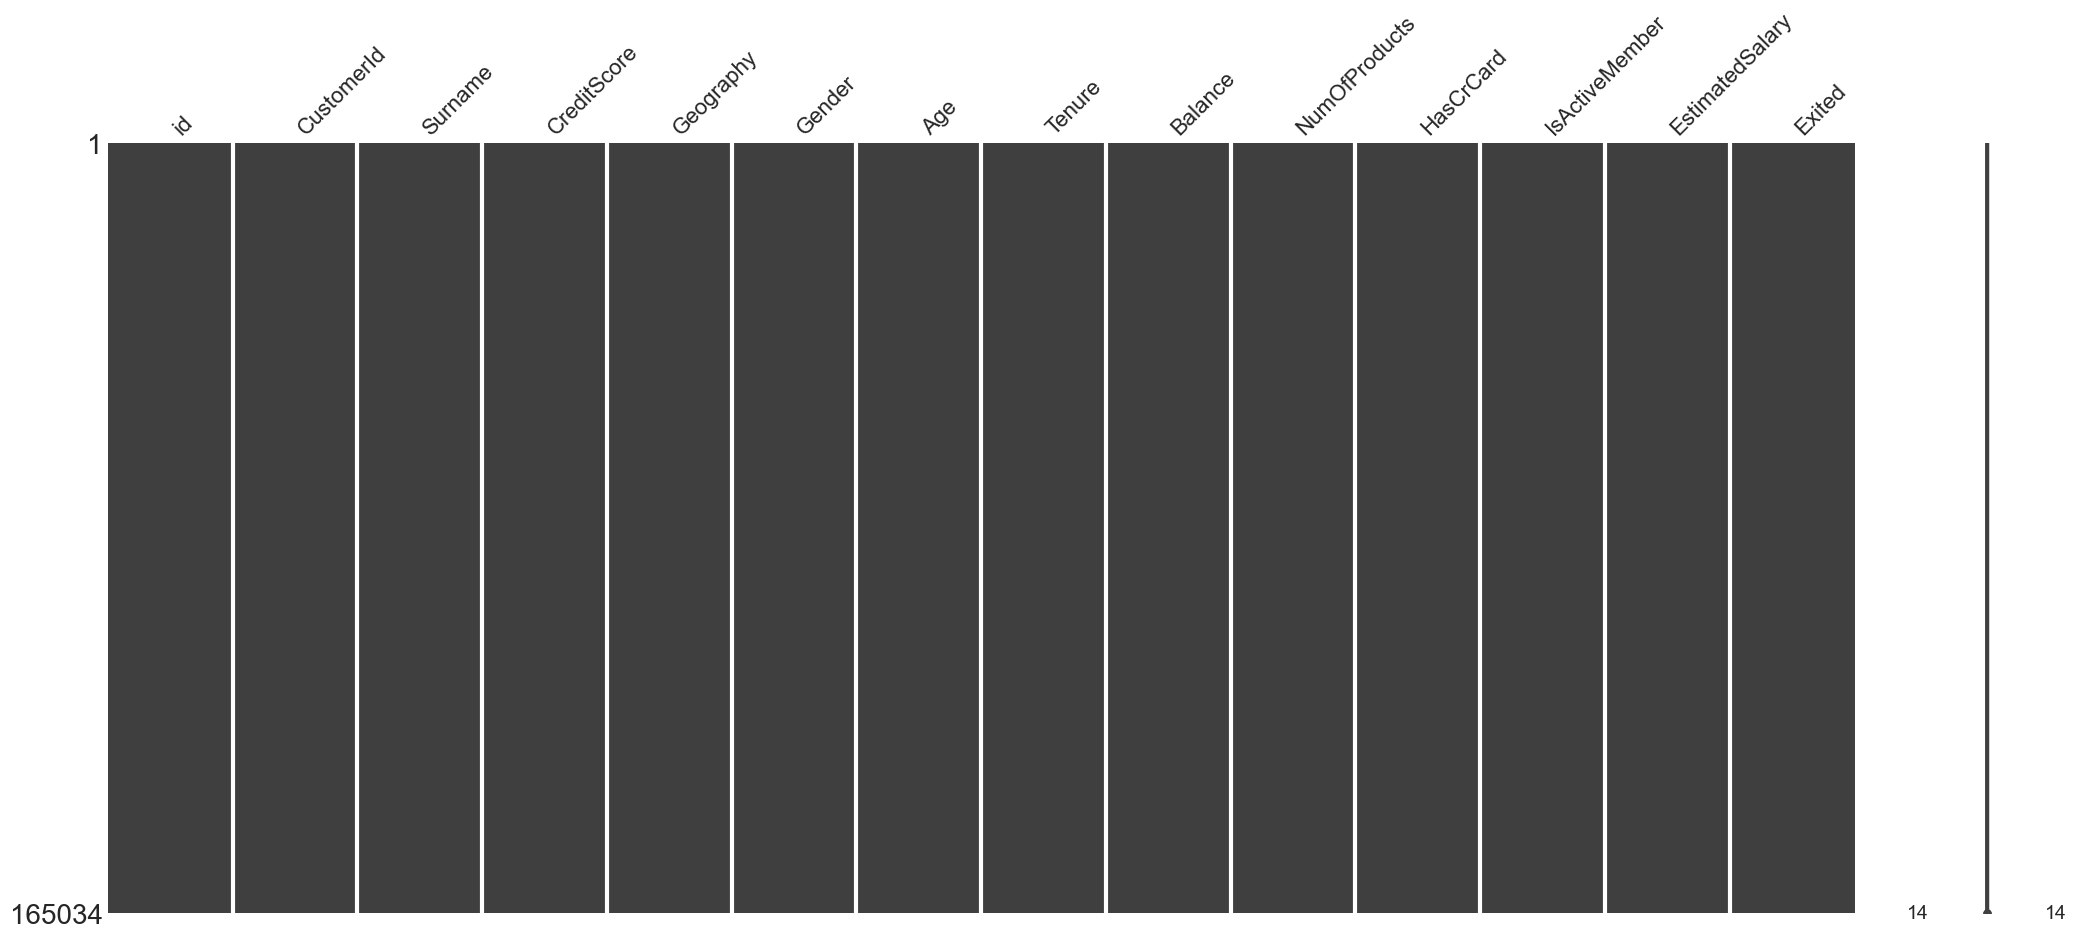

In [51]:
msno.matrix(train_df);

> ## **Des données dupliquées! Vérifions voir?**

In [52]:

duplicated_value = train_df.duplicated(subset=["id"], keep=False)
df_customer_duplicate = train_df[duplicated_value].sort_values(by=["id"])

df_customer_duplicate

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


In [53]:
train_df.duplicated().any()

False

In [54]:

duplicated_value = test_df.duplicated(subset=["id"], keep=False)
df_customer_duplicate = test_df[duplicated_value].sort_values(by=["id"])


df_customer_duplicate

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary


In [55]:
# Check for the duplicates: if True then there are duplicated
test_df.duplicated().any()

False

> **Il n'y a pas de redondance dans les données et les données ne presentent pas de valeurs manquantes**

> ## **L'ANALYSE EXPLORATOIRE DES DONNEES**


**About dataset/ Description des données**

The bank customer churn dataset is a commonly used dataset for predicting customer churn in the banking industry.


It contains information on bank customers who either left the bank or continue to be a customer. 

The dataset includes the following attributes:

Customer ID: A unique identifier for each customer

Surname: The customer's surname or last name

Credit Score: A numerical value representing the customer's credit score

Geography: The country where the customer resides (France, Spain or Germany)

Gender: The customer's gender (Male or Female)

Age: The customer's age.

Tenure: The number of years the customer has been with the bank

Balance: The customer's account balance

NumOfProducts: The number of bank products the customer uses (e.g., savings account, credit card)

HasCrCard: Whether the customer has a credit card (1 = yes, 0 = no)

IsActiveMember: Whether the customer is an active member (1 = yes, 0 = no)

EstimatedSalary: The estimated salary of the customer

Exited: Whether the customer has churned (1 = yes, 0 = no)

> ## **L'ANALYSE UNIVARIEE**

In [56]:
sns.set_style("white")
sns.set(rc={"axes.facecolor":"#E8CE9D","figure.facecolor":"#E8CE9D","grid.color":"white"})
sns.set_context("poster",font_scale = .7)

palette = ["#764a23","#f7941d","#6c9a76","#f25a29","#cc4b57"]
palette_cmap = ["#6c9a76","#cc4b57","#764a23","#f25a29","#f7941d"]

> ### **Quelles sont les informations sur la variable Exited?**

>> #### train_df

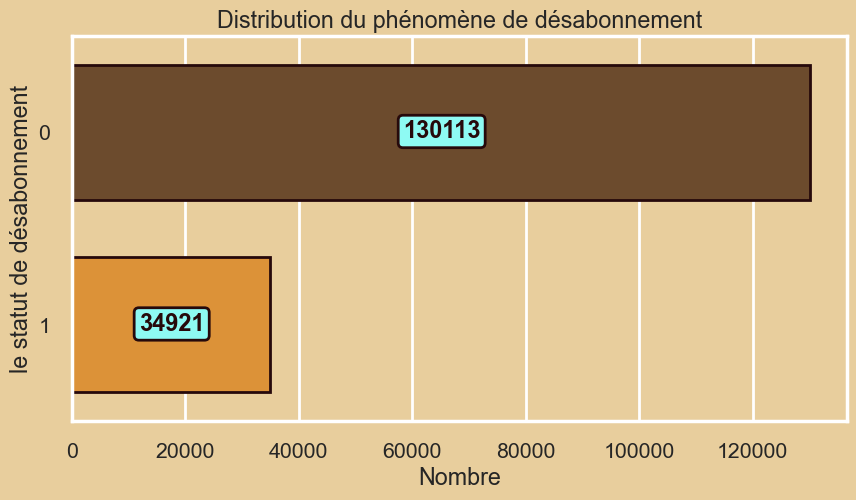

In [57]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Exited", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution du phénomène de désabonnement")
plt.xlabel("Nombre")
plt.ylabel("le statut de désabonnement")

plt.show()


> ### **Quelles sont les informations sur la variable Credit Score?**

>> #### train_df

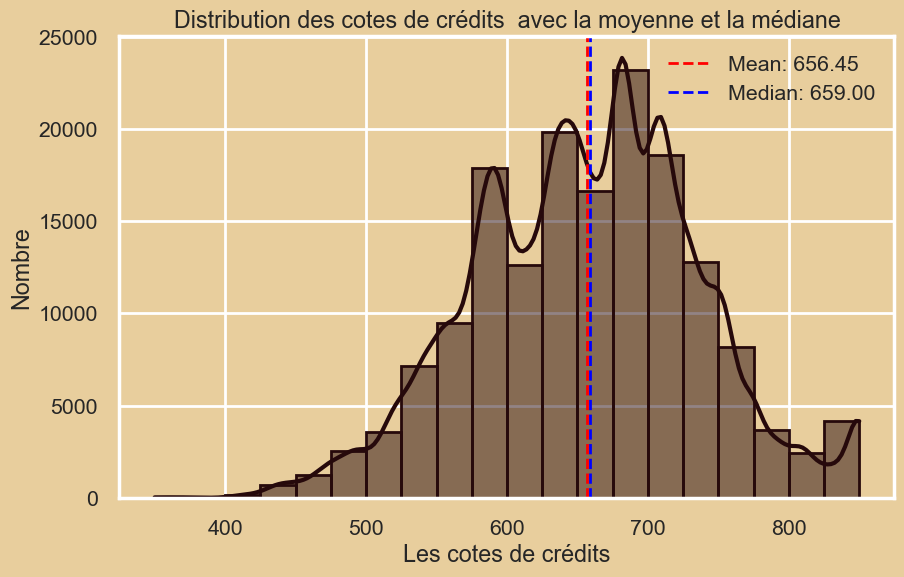

In [58]:
# Create a histogram for the "CreditScore" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=train_df, x="CreditScore", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["CreditScore"].mean()
median_value = train_df["CreditScore"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution des cotes de crédits  avec la moyenne et la médiane")
plt.xlabel("Les cotes de crédits")
plt.ylabel("Nombre")

# Show legend
plt.legend()

plt.show()


> ### **Quelles sont les informations sur la variable Geography?**

>> #### train_df

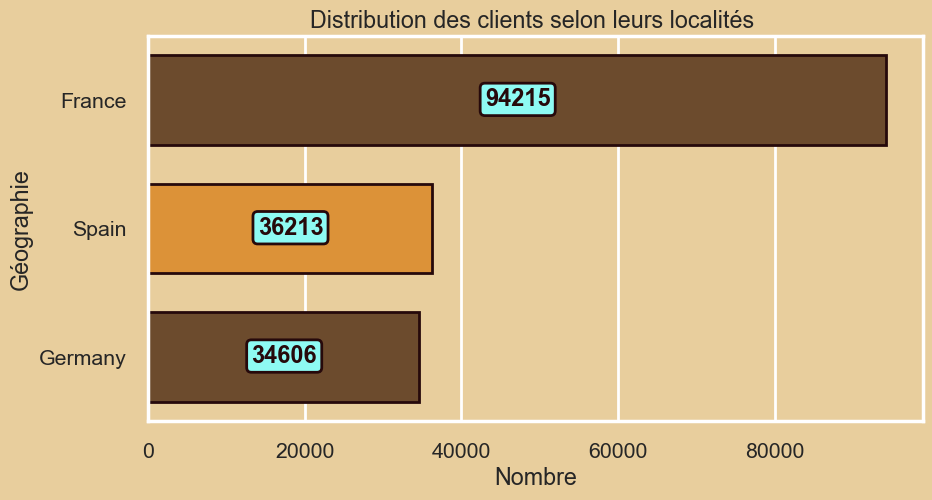

In [59]:
fig = plt.figure(figsize=(10, 5))


p = sns.countplot(y="Geography", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution des clients selon leurs localités ")
plt.xlabel("Nombre")
plt.ylabel("Géographie")

plt.show()


> ### **Quelles sont les informations sur la variable Gender?**

>> #### train_df

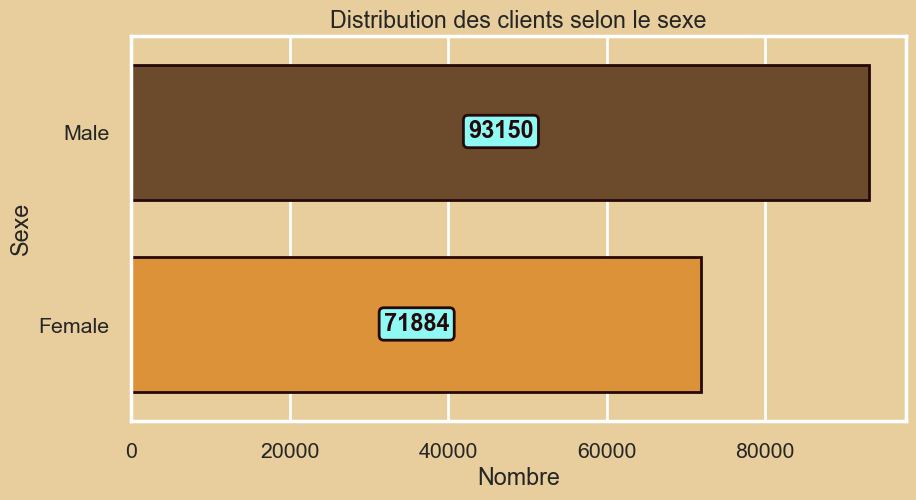

In [60]:

fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Gender", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution des clients selon le sexe")
plt.xlabel("Nombre")
plt.ylabel("Sexe")

plt.show()


> ### **Quelles sont les informations sur la variable Age?**

>> #### train_df

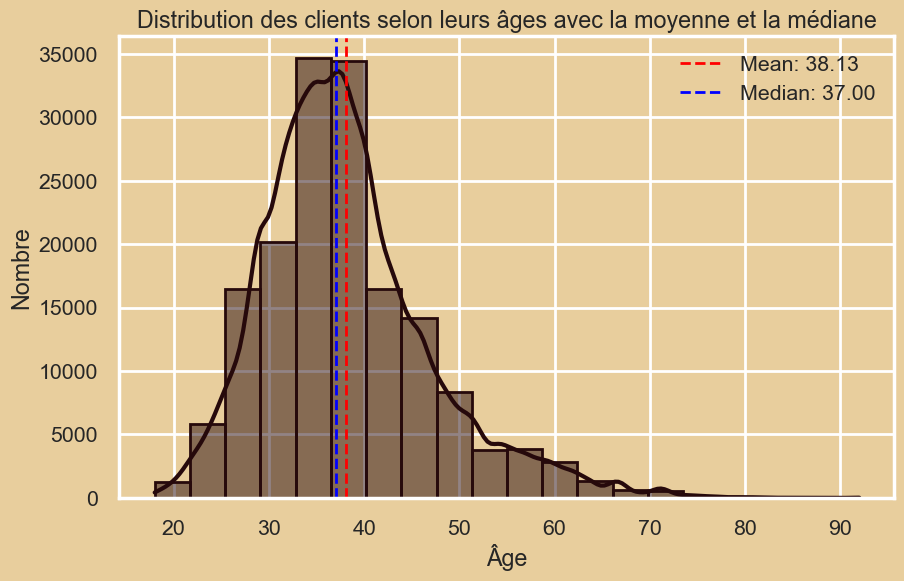

In [61]:
# Create a histogram for the "Age" column with specified colors
fig = plt.figure(figsize=(10, 6))

histplot = sns.histplot(data=train_df, x="Age", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["Age"].mean()
median_value = train_df["Age"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution des clients selon leurs âges avec la moyenne et la médiane")
plt.xlabel("Âge")
plt.ylabel("Nombre")

# Show legend
plt.legend()

plt.show()


> ### **Quelles sont les informations sur la variable Tenure?**

>> #### train_df

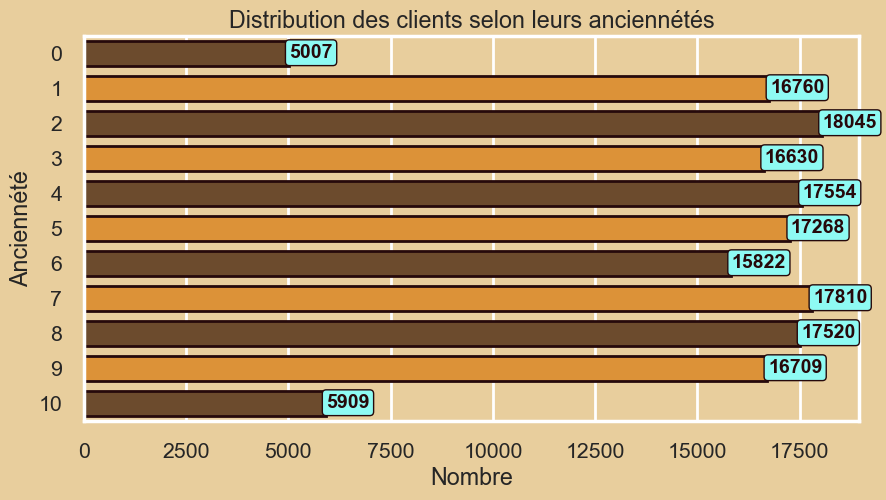

In [62]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="Tenure", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="edge", color='#26090b', fontsize=14, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 1, "alpha": 1})

plt.title("Distribution des clients selon leurs anciennétés")
plt.xlabel("Nombre")
plt.ylabel("Anciennété")

plt.show()


> ### **Quelles sont les informations sur la variable Balance?**

>> #### train_df

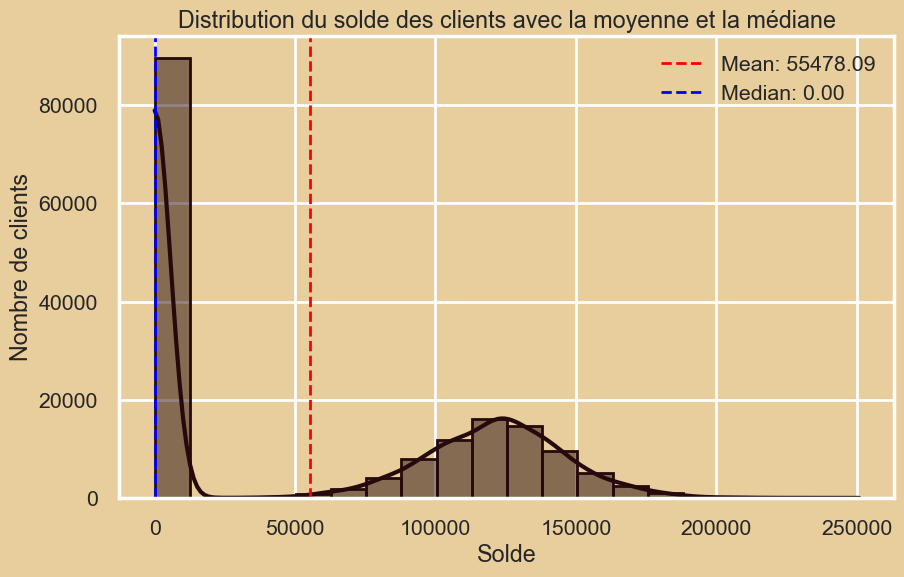

In [63]:
# Create a histogram for the "Balance" column with specified colors
fig= plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=train_df, x="Balance", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["Balance"].mean()
median_value = train_df["Balance"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution du solde des clients avec la moyenne et la médiane")
plt.xlabel("Solde")
plt.ylabel("Nombre de clients")

# Show legend
plt.legend()

plt.show()

> ### **Quelles sont les informations sur la variable Number Of Products?**

>> #### train_df

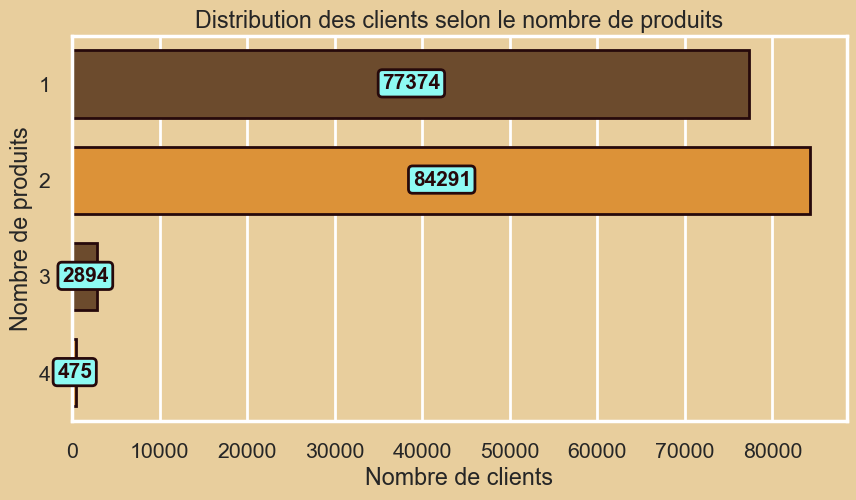

In [64]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="NumOfProducts", data=train_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color='#26090b', fontsize=15, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution des clients selon le nombre de produits")
plt.xlabel("Nombre de clients")
plt.ylabel("Nombre de produits")

plt.show()


> ### **Quelles sont les informations sur la variable Having Credit Card?**

>> #### train_df

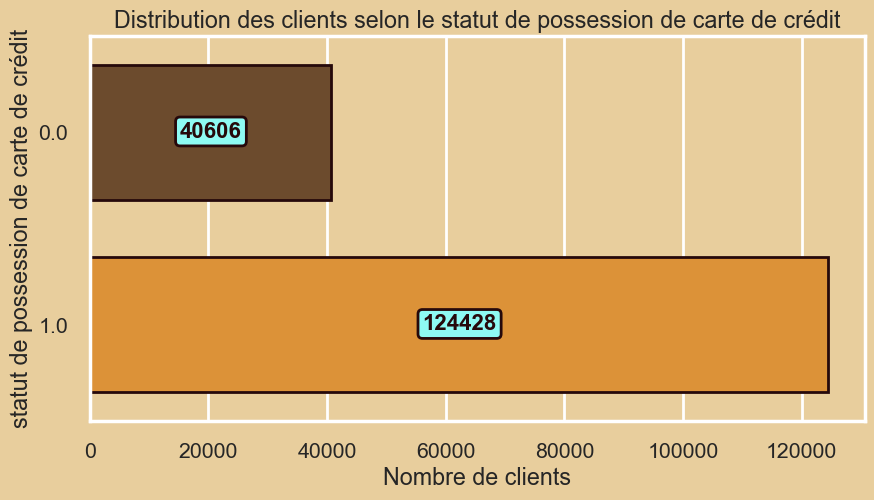

In [65]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="HasCrCard", data=train_df, palette=palette[0:2]
                  , edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=16, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution des clients selon le statut de possession de carte de crédit")
plt.xlabel("Nombre de clients")
plt.ylabel("statut de possession de carte de crédit")

plt.show()


> ### **Quelles sont les informations sur la variable Active Customers?**

>> #### train_df

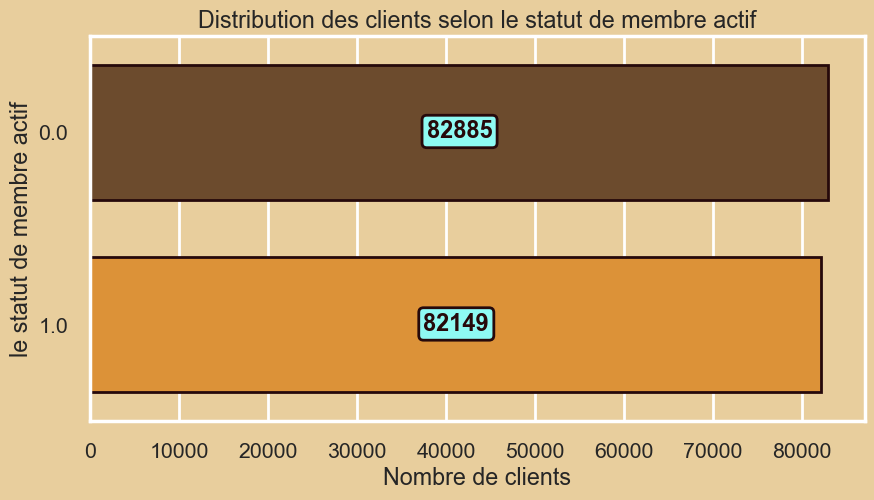

In [66]:
fig = plt.figure(figsize=(10, 5))

p = sns.countplot(y="IsActiveMember", data=train_df, palette=palette[0:2], edgecolor='#26090b', linewidth=2, width=0.7)

# Add text on top of the bars
for container in p.containers:
    plt.bar_label(container, label_type="center", color="#26090b", fontsize=17, weight='bold', padding=6, position=(0.5, 0.5),
                  bbox={"boxstyle": "round", "pad": 0.2, "facecolor": "#8efaf3", "edgecolor": '#26090b', "linewidth": 2, "alpha": 1})

plt.title("Distribution des clients selon le statut de membre actif")
plt.xlabel("Nombre de clients")
plt.ylabel("le statut de membre actif")

plt.show()


> ### **Quelles sont les informations sur la variable Estimated Salary In The Dataset**

>> #### train_df

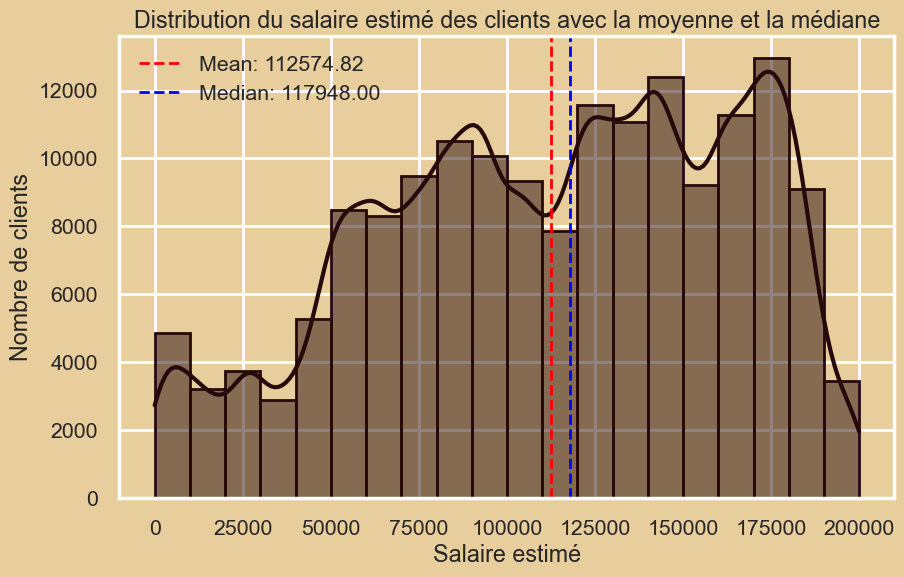

In [67]:
# Create a histogram for the "EstimatedSalary" column with specified colors
fig = plt.figure(figsize=(10, 6))


histplot = sns.histplot(data=train_df, x="EstimatedSalary", bins=20, color='#26090b', edgecolor='#26090b', kde=True)

# Set the color for the kernel density line
histplot.get_lines()[0].set_color('#26090b')

# Calculate mean and median
mean_value = train_df["EstimatedSalary"].mean()
median_value = train_df["EstimatedSalary"].median()

# Add mean and median lines
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.2f}')
plt.axvline(median_value, color='blue', linestyle='dashed', linewidth=2, label=f'Median: {median_value:.2f}')

# Set labels and title
plt.title("Distribution du salaire estimé des clients avec la moyenne et la médiane")
plt.xlabel("Salaire estimé")
plt.ylabel("Nombre de clients")

# Show legend
plt.legend()

plt.show()

> ### **ANALYSE BIVARIEE SELON LA VARIABLE CIBLE**

>> #### train_df

In [68]:
cat_cols = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember']

num_cols = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

target = 'Exited'

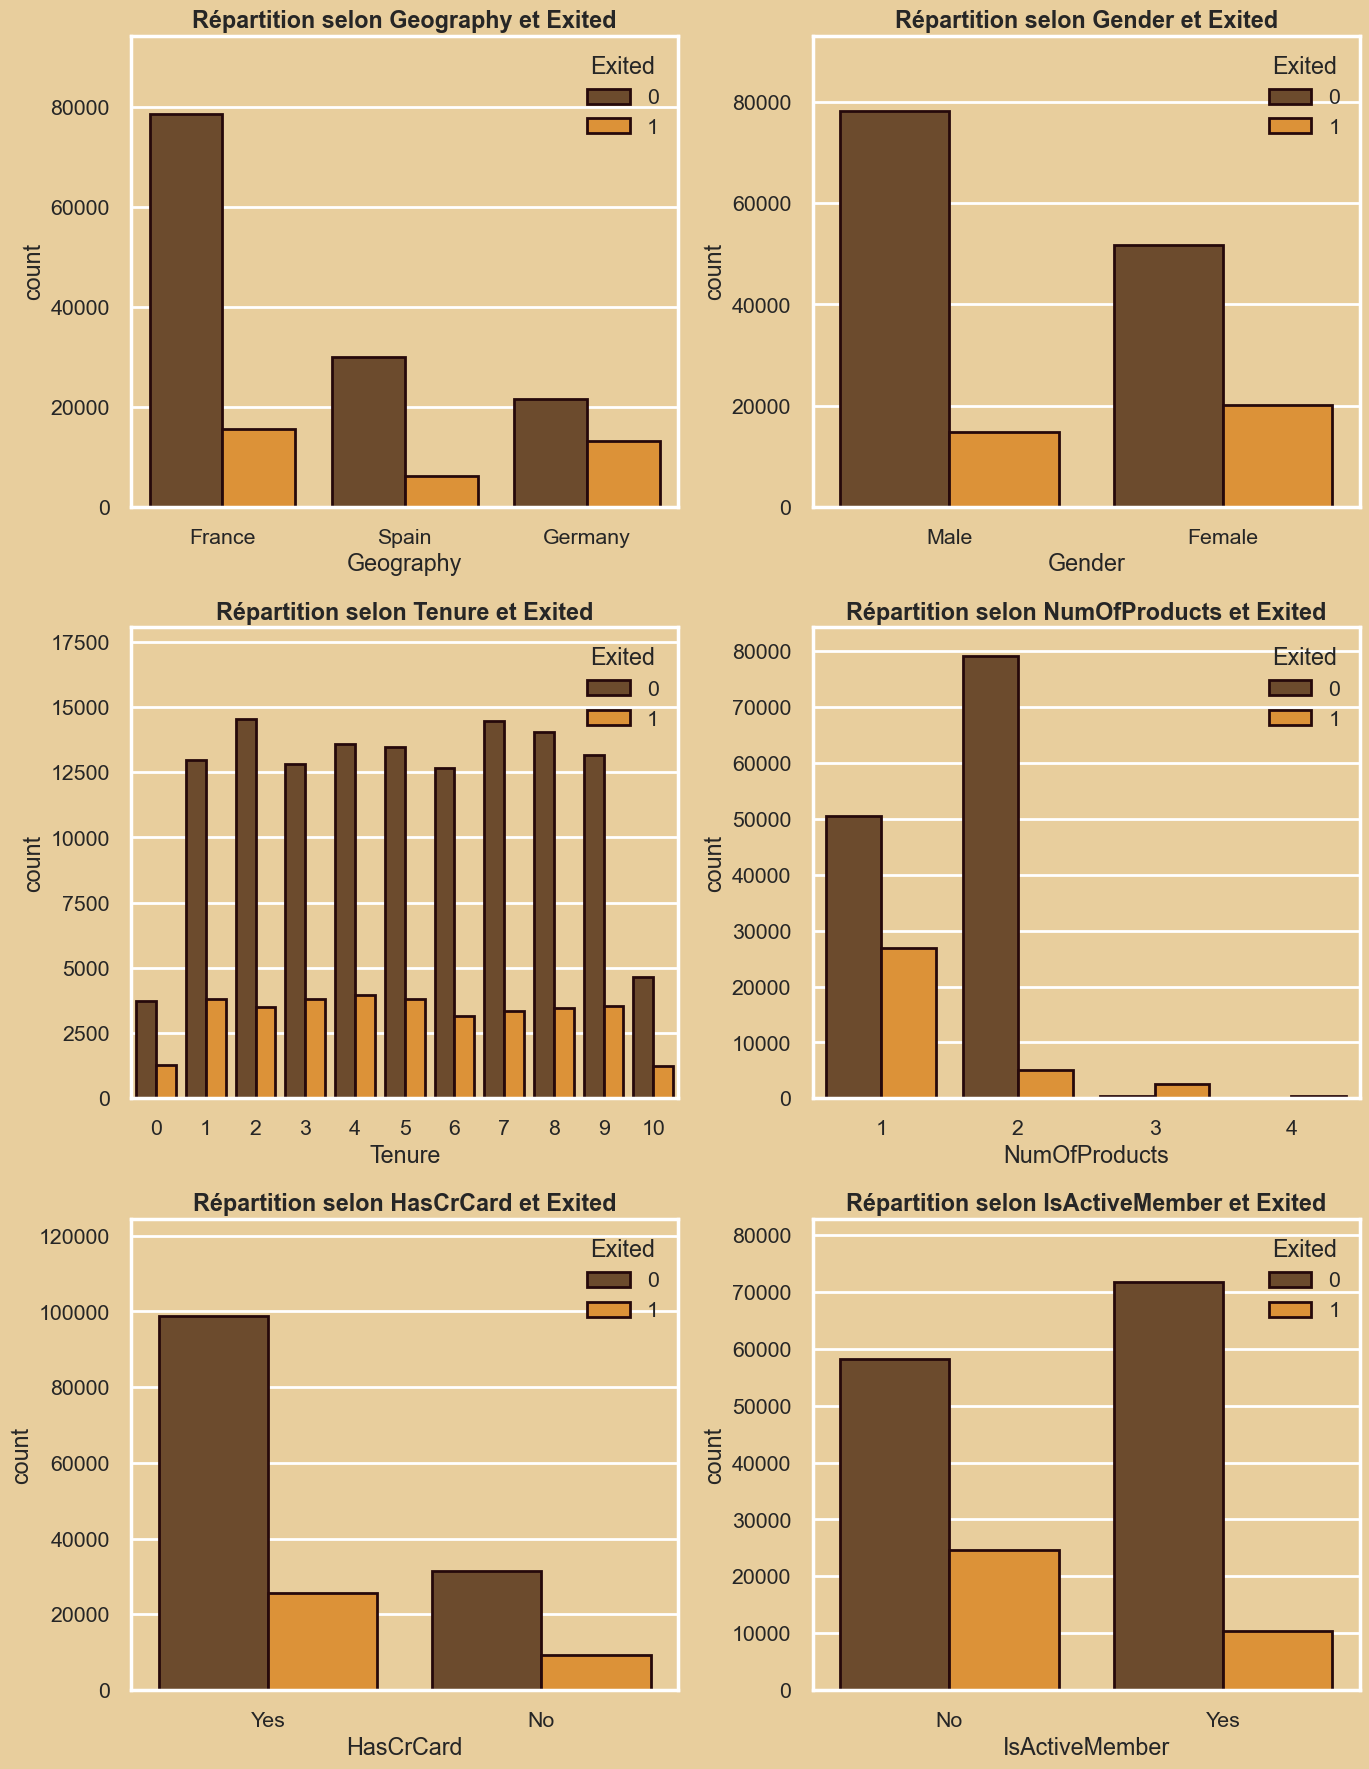

In [73]:
fig = plt.figure(figsize=(14, len(cat_cols)*3))

# background_color = 'grey'
for i, col in enumerate(cat_cols):
    
    plt.subplot(len(cat_cols)//2 + len(cat_cols) % 2, 2, i+1)
    sns.countplot(x=col, hue=target, data=train_df, palette=palette[0:2], color='#26090b', edgecolor='#26090b')
    plt.title(f"Répartition selon {col} et Exited", fontweight = 'bold')
    plt.ylim(0, train_df[col].value_counts().max() + 10)
    
plt.tight_layout()
plt.show()

<Axes: >

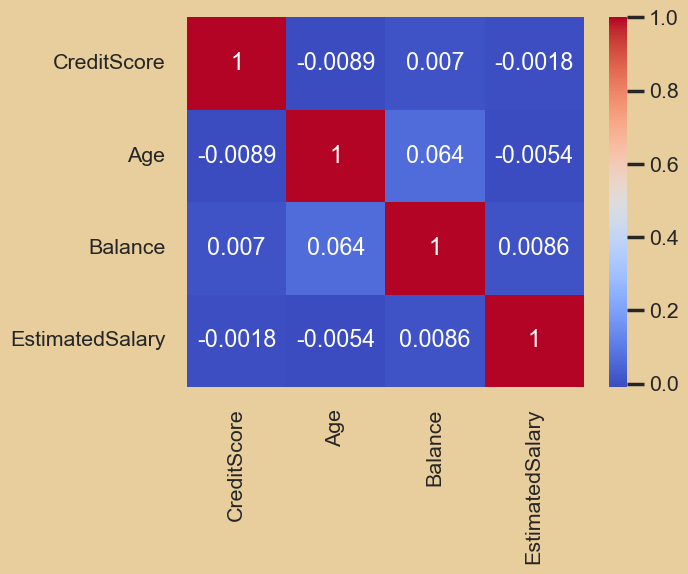

In [70]:
corr = train_df[num_cols].corr()
sns.heatmap(corr,cmap='coolwarm',annot=True)

>> #### test_df

<Axes: >

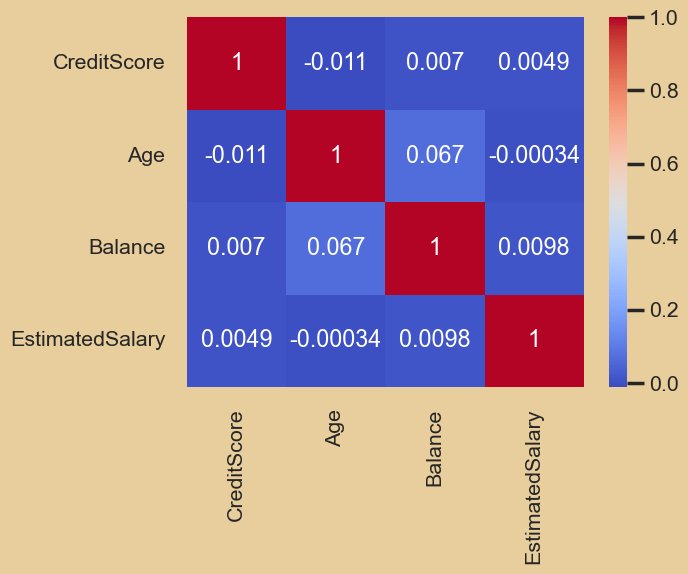

In [71]:
corr = test_df[num_cols].corr()
sns.heatmap(corr,cmap='coolwarm',annot=True)

In [72]:
def map(data):
    """Mappe les valeurs binaires 0/1 vers 'No'/'Yes'."""
    binary_mapping = {0: 'No', 1: 'Yes'}
    binary_cols = ['HasCrCard', 'IsActiveMember']
    for col in binary_cols:
        if col in data.columns:
            data[col] = data[col].map(binary_mapping)
    return data
map(train_df)
afficher_dataframes(train_df)


📄 DESCRIPTION
📐 Taille : 165034 lignes × 14 colonnes
🧠 Colonnes : ['id', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,Yes,No,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,Yes,Yes,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,Yes,No,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,Yes,Yes,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,Yes,Yes,15068.83,0


<div style="background-color: RGB(80,115,152); text-align: center;">
    <h1 style="margin: auto; padding: 20px; color:#fff;"> CONCUSION </h1>
</div>

<font size=4 style="line-height: 1.5;">
Sur la base de l'analyse de l'ensemble des données relatives à l'attrition de la clientèle des banques, nous avons recueilli des informations précieuses pour comprendre et prédire l'attrition de la clientèle.<br><br>
    
Tout d'abord, nous avons identifié l'énoncé du problème, qui consiste à prédire si un client conservera son compte ou s'il le quittera. L'ensemble de données comprend divers attributs tels que l'identifiant du client, la cote de crédit, la géographie, le sexe, l'âge, l'ancienneté, le solde, le nombre de produits, le statut de la carte de crédit, le statut de l'activité, le salaire estimé et le statut du désabonnement.<br><br>

Une analyse plus poussée a révélé que l'ensemble de données se compose plus de clients masculins . Nous avons également identifié la présence de soldes nuls, probablement dus au fait que les clients utilisent la banque pour des opérations autres que l'épargne. En outre, le pourcentage de membres non actifs est élevé, ce qui pourrait être un facteur prédictif de désabonnement.<br><br>

Sur le plan géographique, l'Allemagne présente le taux de désabonnement le plus élevé, tandis que les femmes affichent un taux de désabonnement plus élevé malgré leur présence moindre dans l'ensemble des données par rapport aux hommes.<br><br>

L'analyse de corrélation a révélé de faibles corrélations linéaires entre le taux de désabonnement et certaines caractéristiques telles que l'âge, le taux d'abandon du nom de famille, le nombre de membres actifs, le nombre de produits et le solde. La distribution des âges parmi les clients résiliés semble normale, ce qui indique qu'aucun groupe d'âge spécifique n'a une propension plus élevée à résilier.<br><br>

Les visualisations indiquent que les clients qui se désistent ont tendance à ne pas avoir de carte de crédit et à être des membres non actifs. En outre, l'impact de l'adhésion active sur le désabonnement est significatif, tandis que la détention d'une carte de crédit a un effet mineur.<br><br>

En conclusion, en tirant parti des connaissances acquises grâce à l'analyse exploratoire et à l'ingénierie des caractéristiques, nous sommes en mesure d'élaborer des modèles prédictifs permettant d'identifier les churners potentiels et de mettre en œuvre des stratégies de fidélisation ciblées afin d'atténuer l'attrition de la clientèle.
</font>
